In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt

In [61]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.2.0


In [62]:
dataset = pd.read_csv('../data/aggregated_metadata_sentiment_frequency_by_topics.csv', index_col=0)

In [63]:
dataset

,retweet_count_1,retweet_count_2,retweet_count_3,retweet_count_4,retweet_count_5,retweet_count_6,retweet_count_7,retweet_count_8,retweet_count_9,retweet_count_10,...,freq_4,freq_5,freq_6,freq_7,freq_8,freq_9,freq_10,GSPC,IXIC,VGT
4/1/16,1985.357143,7542.333333,2248.00,2714.571429,6065.00000,2062.666667,1539.500000,2324.5,1449.333333,4195.00000,...,7,1,3,2,2,3,2,3380.800049,11326.509770,315.329987
5/1/16,1286.000000,1159.000000,1049.00,1092.000000,0.00000,1571.000000,932.000000,0.0,1325.750000,0.00000,...,1,0,4,1,0,4,0,3363.000000,11167.509770,311.450012
6/1/16,2096.250000,800.000000,3134.20,1237.000000,2517.00000,2341.000000,0.000000,0.0,724.000000,0.00000,...,1,1,1,0,0,3,0,3335.469971,11085.250000,309.149994
7/1/16,1471.000000,0.000000,6813.50,1726.500000,1393.00000,1588.500000,0.000000,0.0,1114.500000,2026.00000,...,2,3,2,0,0,2,1,3351.600098,11117.530270,310.000000
8/1/16,2246.333333,0.000000,1014.00,1548.000000,1425.00000,1688.666667,0.000000,1968.0,0.000000,0.00000,...,2,1,3,0,1,0,0,3298.459961,10913.559570,304.359985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25/9/20,13841.125000,7468.823529,9028.75,11875.416670,17963.90909,13305.666670,5581.083333,13394.0,17808.250000,5749.50000,...,12,11,3,12,4,4,2,1922.030029,4643.629883,94.776695
28/9/20,14742.000000,9792.750000,26678.20,25413.666670,19582.33333,29004.500000,8355.521739,20924.0,19850.000000,30891.55556,...,6,3,6,23,6,1,9,1943.089966,4689.430176,95.597809
29/9/20,19296.200000,6911.500000,8287.00,15762.000000,32283.50000,36918.500000,0.000000,13933.2,22894.000000,17406.66667,...,2,2,2,0,5,1,3,1990.260010,4835.759766,98.778427
30/9/20,20460.000000,14327.750000,24470.75,13862.222220,20833.27273,17549.750000,32909.000000,16050.0,13780.142860,9885.60000,...,9,11,4,1,3,7,10,2016.709961,4891.430176,100.137505


### train-test split

In [64]:
train_dataset = dataset.sample(frac=0.75, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#### predict GSPC

In [65]:
train_feature = train_dataset.iloc[:,:-3].copy()
test_feature = test_dataset.iloc[:,:-3].copy()

train_gspc = train_dataset['GSPC']
test_gspc = test_dataset['GSPC']

In [66]:
# normalise
normalizer = preprocessing.Normalization(input_shape=[150,])
normalizer.adapt(np.array(train_feature))

In [67]:
# create model
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 150)               301       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                9664      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 14,190
Trainable params: 13,889
Non-trainable params: 301
_________________________________________________________________


In [68]:
history = dnn_model.fit(
    train_feature, train_gspc,
    validation_split=0.2,
    verbose=0, epochs=100)

In [69]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2000])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

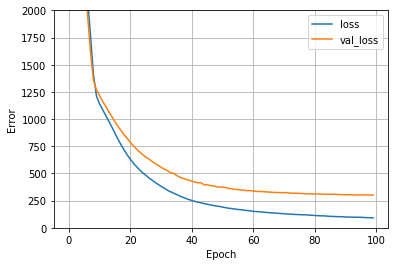

In [70]:
plot_loss(history)

In [71]:
# retrieve the MAPE on the test set

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

mean_absolute_percentage_error(test_gspc, dnn_model.predict(test_feature)) #MAPE

12.208955695697679

In [72]:
# RMSE
sqrt(mean_squared_error(dnn_model.predict(test_feature), test_gspc))

402.657588375739

#### predict IXIC

In [73]:
train_ixic = train_dataset['IXIC']
test_ixic = test_dataset['IXIC']

In [84]:
history_ixic = dnn_model.fit(
    train_feature, train_ixic,
    validation_split=0.2,
    verbose=0, epochs=100)

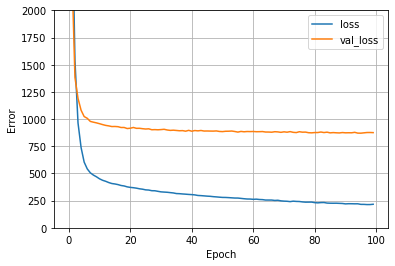

In [75]:
plot_loss(history_ixic)

In [76]:
#MAPE
mean_absolute_percentage_error(test_ixic, dnn_model.predict(test_feature)) 

14.087932328009236

In [77]:
# RMSE
sqrt(mean_squared_error(dnn_model.predict(test_feature), test_ixic))

1230.0313907048421

#### predict VGT

In [78]:
train_vgt = train_dataset['VGT']
test_vgt = test_dataset['VGT']

In [79]:
history_vgt = dnn_model.fit(
    train_feature, train_vgt,
    validation_split=0.2,
    verbose=0, epochs=100)

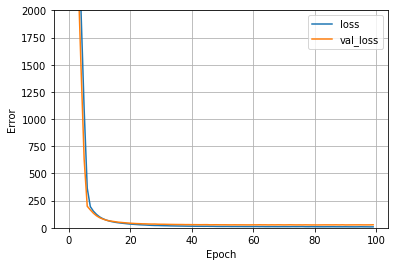

In [80]:
plot_loss(history_vgt)

In [81]:
mean_absolute_percentage_error(test_vgt, dnn_model.predict(test_feature)) #MAPE

18.706604676112505

In [82]:
# RMSE
sqrt(mean_squared_error(dnn_model.predict(test_feature), test_vgt))

38.466189122478745